In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set()

df = pd.read_csv('/content/oasis_eeg2.csv', index_col=None)

In [48]:
df.head()

,Subject ID,Group,Visit,M/F,Hand,Age,C1,C2,C3,C4,C5,C6,C7
0,OAS2_0001,0,1,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0004,0,1,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
2,OAS2_0005,0,1,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
3,OAS2_0008,0,1,F,R,93,14,2.0,30.0,0.0,1272,0.698,1.380
4,OAS2_0009,1,1,M,R,68,12,2.0,27.0,0.5,1457,0.806,1.205


#Drop null values from the dataset

In [35]:
df = df.dropna(axis=0, how='any')

#EDA

In [36]:
df = df.loc[df['Visit']==1]
df = df.reset_index(drop=True)
#df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0])

In [37]:
df.head()

,Unnamed: 0,Subject ID,Group,Visit,M/F,Hand,Age,C1,C2,C3,C4,C5,C6,C7
0,0,OAS2_0001,0,1,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,5,OAS2_0004,0,1,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
2,7,OAS2_0005,0,1,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
3,13,OAS2_0008,0,1,F,R,93,14,2.0,30.0,0.0,1272,0.698,1.380
4,15,OAS2_0009,1,1,M,R,68,12,2.0,27.0,0.5,1457,0.806,1.205


#Plot of Gender

In [38]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

Text(0.5, 1.0, 'Gender and Demented rate')

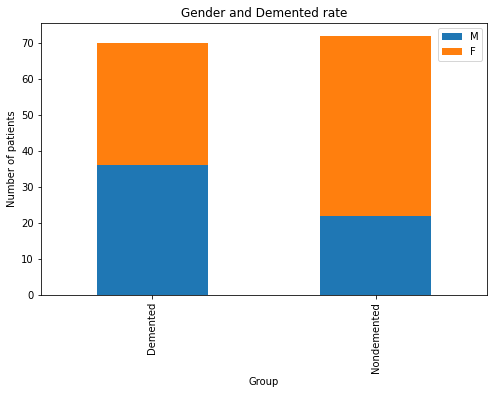

In [39]:
# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

#Plot of Age factor

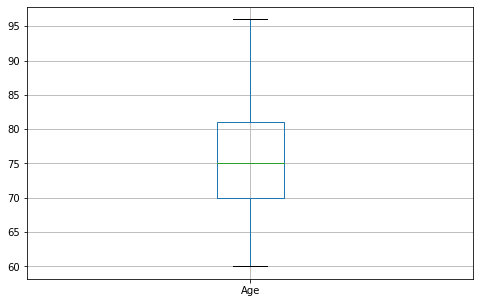

In [40]:
df.boxplot('Age', figsize=(8,5))

#Classification Model

##Data preprocessing

In [ ]:
def normalize(df):
    result = df.copy()
    
    for feature_name in df.columns:
      if feature_name not in ['Group', 'M/F', 'Age']:
          max_value = df[feature_name].max()
          min_value = df[feature_name].min()
          result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
normalized_df = normalize(df)

In [ ]:
Y = df['Group'].values

##Dataset splitting into train, validation and test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [ ]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

##Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

###Logistic Regression

In [ ]:
acc = []

best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval, Y_trainval)

test_score = SelectedLogRegModel.score(X_test, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


Best accuracy on validation set is: 0.8861471861471862
Best parameter for regularization (C) is:  100
Test accuracy with best C parameter is 0.9722222222222222
Test recall with the best C parameter is 0.9411764705882353
Test AUC with the best C parameter is 0.9705882352941176


###SVM

In [ ]:
#acc2 = []
best_score = 0

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, 
                           gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval, Y_trainval, 
                                     cv=kfolds, scoring='accuracy')
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
            

SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, 
                       kernel=best_parameter_k).fit(X_trainval, Y_trainval)

test_score = SelectedSVMmodel.score(X_test, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on cross validation set is: 0.8861471861471862
Best parameter for c is:  0.001
Best parameter for gamma is:  10
Best parameter for kernel is:  poly
Test accuracy with the best parameters is 0.9722222222222222
Test recall with the best parameters is 0.9411764705882353
Test recall with the best parameter is 0.9705882352941176


###Decision Tree

In [ ]:
best_score = 0

for md in range(1, 8):
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    scores = cross_val_score(treeModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy')
    
    score = np.mean(scores)

    if score > best_score:
        best_score = score
        best_parameter = md
    
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval, Y_trainval )

test_score = SelectedDTModel.score(X_test, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8861471861471862
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.9722222222222222
Test recall with best parameters is  0.9411764705882353
Test AUC with the best parameter is  0.9705882352941176


###Random Forest Classifier

In [ ]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 8): # maximum number of features considered at each split
        for m in range(1, 7): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval, Y_trainval, 
                                     cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m
  
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test)
test_score = SelectedRFModel.score(X_test, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8861471861471862
Best parameters of M, d, m are:  2 2 1
Test accuracy with the best parameters is 0.9166666666666666
Test recall with the best parameters is: 0.9411764705882353
Test AUC with the best parameters is: 0.9179566563467493


###AdaBoost

In [ ]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr
  
SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_trainval, Y_trainval )

PredictedOutput = SelectedBoostModel.predict(X_test)
test_score = SelectedRFModel.score(X_test, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8861471861471862
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.9166666666666666
Test recall with the best parameters is: 0.9411764705882353
Test AUC with the best parameters is: 0.891640866873065


#Results

In [ ]:
# Performance Metric for each model
#result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Logistic Regression (w/ imputation),0.972222,0.941176,0.970588
1,SVM,0.972222,0.941176,0.970588
3,Decision Tree,0.972222,0.941176,0.970588
4,Random Forest,0.916667,0.941176,0.917957
5,AdaBoost,0.916667,0.941176,0.891641
